In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#  Symmpy
from sympy import Symbol, diff, erf, sqrt, init_printing, ln, exp, diff, pi

#  For printing nice Sympy results
from IPython.display import display
init_printing()

%matplotlib inline

## References
Stack Exchange derivation of the price of a call: https://quant.stackexchange.com/questions/32863/bachelier-model-call-option-pricing-formula
Academic Paper pn the relation between Black-Scholes and Bachelier https://www.mat.univie.ac.at/~schachermayer/preprnts/prpr0121.pdf

Github notebook on Numerical Antiderivative models in Python: https://github.com/kpmooney/numerical_methods_youtube


##  Black Scholes Functions
- Black Scholes call and put prices
-  Objective functions for finding volatility
- Function for vega, the derivative of option price with respect to volatility

The Black-Scholes price of a call is given by,
$$C = \Phi(d_1) S - \Phi(d_2) K e^{-r t},$$
and the price of a put by,
$$P = \Phi(-d_2)e_{-rt} - \Phi(-d_1)S,$$
where
$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ \ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma.^2}{2}\right) t\right],$$
and
$$d_2 = d_1 - \sigma \sqrt{t}.$$

In [47]:
def call_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C, d1, d2

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

def call_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return call_price(sigma, S, K, r, t) - price

def put_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return put_price(sigma, S, K, r, t) - price

def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)

## Bachelier Model

$$
C = e^{-rt} \left(Se^{rt}-K\right)
\Phi\left( \frac{Se^{rt}-K}{ \sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}} \right) + 
e^{-rt}\sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}
\phi\left(  \frac{Se^{rt}-K}{ \sqrt{\frac{\sigma^2}{2r}(e^{2rt} - 1)}} \right)
$$

In [7]:
def bachelier(sigma, S, K, r, t):
    d = (S * np.exp(r*t) - K) / np.sqrt(sigma**2/(2 * r) * (np.exp(2*r*t)-1) )
   
    C = np.exp(-r * t) * (S * np.exp(r * t) - K) * norm.cdf(d) + \
        np.exp(-r * t) * np.sqrt(sigma**2/(2*r) * (np.exp(2*r*t)-1) ) * norm.pdf(d)

    return C

Text(0, 0.5, 'Call Price ($)')

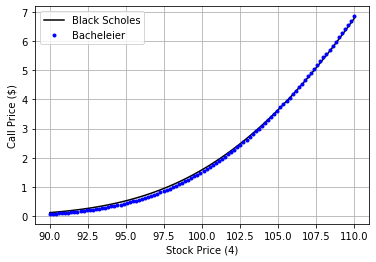

In [8]:
t = 30 / 365    #  Time to expiration
sigma = 0.30    #  Black Scholes implied volatility
K = 105         #  Strike Price
r = 0.01        #  Risk-free rate

S = np.linspace(90, 110, 100)    # Let our stock price range between $90 and $110

#  Calculate option prices based on both models
C_bs, d1, d2 = call_price(sigma, S, K, r, t)
C_ba = bachelier(sigma * S, S, K, r, t)

#  Plot the results
plt.plot(S, C_bs, 'k', label = 'Black Scholes')
plt.plot(S, C_ba, 'b.', label = 'Bacheleier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Call Price ($)')

Let's calculate $\Delta$ for the Bachelier model using a finite-difference technique to take the derivative. Let's do this for an at-the-money call with a strike price of $105. We'll keep the other parameters the same as above.

We'll use,
$$\frac{dr}{dx} \approx \frac{f(x + \epsilon) + f(x)}{\epsilon}$$
as our approximation for the derivative.

In [11]:
t = 30 / 365
sigma = 0.30
K = 105
r = 0.01
S = 105

#  For Black Scholes, we have a formula  for delta: Delta = norm.cds(d1)
C_bs, d1, d2 = call_price(sigma, S, K, r, t)
Delta_bs = norm.cdf(d1)
print('Delta BS = ', Delta_bs)

#  Set epsilon to a small number
epsilon = 1e-6

#  Calculate the call prices
C1_ba = bachelier(sigma * S, S, K, r, t)
C2_ba = bachelier(sigma * S, S + epsilon, K, r, t)

#  Estimate Delta
Delta_ba = (C2_ba - C1_ba) / epsilon
print('Delta BA = ', Delta_ba)


def estimate_delta(call1, call2):
    #  Set epsilon to a small number
    epsilon = 1e-6
    return   (call2 - call1) / epsilon


estimate_delta(C1_ba, C2_ba)

Delta BS =  0.520958769045928
Delta BA =  0.5038124020195767


testing -- using newtons method for roots
(Use this to try to reproduce the same values)

In [12]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    count = 0
    epsilon = 1
    f_return = []
    fprime_return = []
    
    while epsilon >= tol:
        count += 1
        if count >= max_iter:
            print('Exiting on runaway loop.')
            return (R, count)
        
        old_R = R
        
        function_value = f(R, args = args)
        function_derivative = fprime(R, args = args)
        ind = np.where(function_derivative <= 0)
        ind = ind[0]
       
        R = -function_value / function_derivative + R
        
        if ind.size > 0:
            R[ ind ] = R[ ind ] * 0.5 + R[ ind ]
            
        if np.isscalar(R):
            epsilon = np.abs( (R - old_R) /old_R )
        else:
            epsilon = np.linalg.norm( R - old_R, np.Inf)
        
        if debug == True:
            f_return.append(function_value)
            fprime_return.append(function_derivative)
        
    return R, count, epsilon, function_value, function_derivative, f_return, fprime_return

In [14]:
# define our objective function for Bachelier, and calculate Vega using same Detla / Parity method.

def call_ba_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return bachelier(sigma, S, K, r, t) - price

def calculate_vega_ba(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    epsilon = 1e-6
    C1 = bachelier(sigma, S, K, r, t)
    C2 = bachelier(sigma + epsilon, S, K, r, t)

    return (C2 - C1) / epsilon

In [53]:
## See if we can reproduce volatility 

C0 = 3.6445730260768543
S = 105
K = 105
r = 0.01
t = 30/365

args = (S, K, r, t, C0)

R, count, epsilon, function_value, function_derivative, f_return, fprime_return = \
newtons_method(call_ba_objective_function, calculate_vega_ba, 0.5, args = args)

In [68]:
print("Calculated volatility level:",R / S)


approx = np.round(R/S,6)

if approx == sigma:
    print(f"Approximation Correct -- Derived Volatility matches actual. {approx} == {sigma} ? {approx == sigma}")
else:
    print(f"Approximation NOT correct:\n\nSigma: {sigma} \nExpected: {np.round(sigma,6)}, \nGot: {approx}")

Calculated volatility level: 0.3000000000000008
Approximation Correct -- Derived Volatility matches actual. 0.3 == 0.3 ? True


In [21]:
t = 30 / 365    #  Time to expiration
sigma = 0.30    #  Black Scholes implied volatility
K = 90          #  Strike Price
r = 0.01        #  Risk-free rate

S = np.linspace(50, 110, 100)

#### Bachelier Puts -- Derived w Put Call Parity

We already have an expression and coded up a function for the call price.  We can use put-call parity to find the price of a put option

A common way to state put-call parity is,
$$C - P = S - e^{-rt}K.$$ 

So if we know the price of a call, we can get the price of the corresponding put,
$$P = C - S + e^{-rt}K.$$

In the video, I started the stock price at 90 which was the same as our strike.  Below, I changed the price range from 50 to 110.

In [22]:
## Derive Puts using Put Call Parity 

#  Calculate Black Schole put price
P_bs = put_price(sigma, S, K, r, t)

#  Calculate Bachelier call price
C = bachelier(sigma * S, S, K, r, t)

#Use put-call parity to calculate put price
P = C - S + np.exp(-r * t) * K

Text(0, 0.5, 'Call Price ($)')

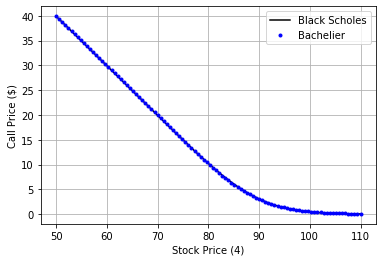

In [24]:
#  Plot the results
plt.plot(S, P_bs, 'k', label = 'Black Scholes')
plt.plot(S, P, 'b.', label = 'Bachelier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Call Price ($)')

Test Using Negatives

In [28]:
t = 30 / 365    #  Time to expiration
sigma = 0.30    #  Black Scholes implied volatility
K = 90          #  Strike Price
r = 0.01        #  Risk-free rate

S = np.linspace(-50, 50, 100)



In [ ]:
#  Calculate Black Schole put price
P_bs = put_price(sigma, S, K, r, t)

#  Calculate Bachelier call price
C = bachelier(sigma * S, S, K, r, t)

#Use put-call parity to calculate put price
P = C - S + np.exp(-r * t) * K




Text(0, 0.5, 'Call Price ($)')

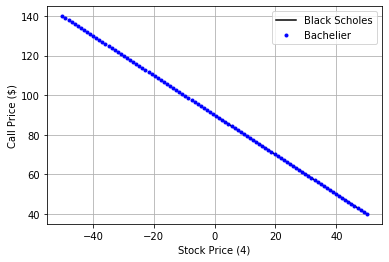

In [30]:
#  Plot the results
plt.plot(S, P_bs, 'k', label = 'Black Scholes')
plt.plot(S, P, 'b.', label = 'Bachelier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Call Price ($)')

In [71]:
## Single Bachelier Call (Negative Underlying)


## Inputs:
t = 30 / 365    #  Time to expiration (% of year -- days / 365)
sigma = 0.30    #  Black Scholes implied volatility (can either be sigma, or discrete )
K = 20          #  Strike Price
r = 0.01        #  Risk-free rate

S = -15 #np.linspace(-50, 50, 100)


#  Calculate Bachelier call price
C = bachelier(sigma * S, S, K, r, t)
S = range(-20,20,1)
S

range(-20, 20)

In [72]:
S = np.linspace(-50,50,100) #Test for prices between -50 and 50 

C = bachelier(sigma * S, S, K, r, t)
print(f'Call prices (for UL from -50 to 50) ranging from {min(C)} to {max(C)}')

Call prices (for UL from -50 to 50) ranging from 0.0 to 30.016431602526843


Text(0, 0.5, 'Call Price ($)')

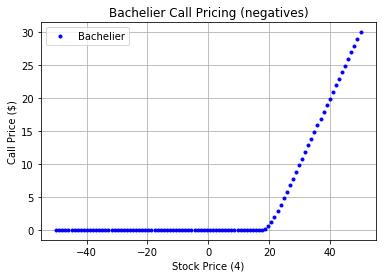

In [75]:
#plt.plot(S, P_bs, 'k', label = 'Black Scholes')
plt.title("Bachelier Call Pricing (negatives)")
plt.plot(S, C, 'b.', label = 'Bachelier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Call Price ($)')

Text(0, 0.5, 'Put Price ($)')

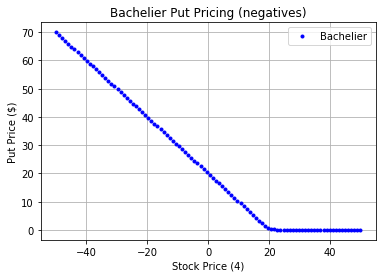

In [77]:
#Use put-call parity to calculate put price
P = C - S + np.exp(-r * t) * K

plt.title("Bachelier Put Pricing (negatives)")
#plt.plot(S, P_bs, 'k', label = 'Black Scholes') #Uncomment to include...
plt.plot(S, P, 'b.', label = 'Bachelier')
plt.grid(True)
plt.legend()
plt.xlabel('Stock Price (4)')
plt.ylabel('Put Price ($)')

## Alternate Methods of Calculation / Helpers
##### Newton Call / Put, simpler IV, simple HV

In [86]:
## Alternate methods (For calculating IV)
import scipy.stats as si

def newton_vol_call(S, K, T, C, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: interest rate
    #sigma: volatility of underlying asset (Stdev)
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - C
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - C) / vega
        
        return abs(xnew)
    
    
    
def newton_vol_put(S, K, T, P, r, sigma):
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0) - P
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - P) / vega
        
        return abs(xnew)
    
    
print(f'Newton Put (IV)',newton_vol_put(25, 20, 1, 7, 0.05, 0.25))
print(f'Newton Call (IV)',newton_vol_call(25, 20, 1, 7, 0.05, 0.25))

Newton Put (IV) 0.1767522047186835
Newton Call (IV) 0.671115789259015


In [87]:
## Alternate IV method... (BS)

import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    '''Estimates Iteratively until prices match... this is best bet.'''
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far


S = 100 #Underliying
K = 100 #Strike
T = 11 #Time (days)
r = 0.01 #RFR
vol = 0.25 #historical -- TOTAL guess here **************

V_market = bs_call(S, K, T, r, vol)
implied_vol = find_vol(V_market, S, K, T, r)

print ('Implied vol: %.2f%%' % (implied_vol * 100))
print ('Market price = %.2f' % V_market)
print ('Model price = %.2f' % bs_call(S, K, T, r, implied_vol))

Implied vol: 25.00%
Market price = 35.94
Model price = 35.94


In [88]:
#https://quant.stackexchange.com/questions/21610/calculating-historical-implied-volatility

In [135]:
import yfinance as yf
import datetime as dt
from dateutil.relativedelta import relativedelta, MO

def quick_hist_vol(symbol, len=30):
    '''
    Produces a quick historical volatility
    (Based on annualized 30d sigma value)
    #https://stackoverflow.com/questions/41293677/annualized-return-in-pandas
    ##https://quant.stackexchange.com/questions/21610/calculating-historical-implied-volatility
    '''
    end = dt.datetime.today()
    beg = end - dt.timedelta(days=len)
    end,beg = end.strftime('%Y-%m-%d'), beg.strftime('%Y-%m-%d')
    data = yf.download(symbol, start=beg, end=end).Close
    sigma = data.pct_change().std()
    ann_sig = (sigma + 1) ** (365.25 / len) - 1
    return ann_sig

    
    
quick_hist_vol('AAPL')

[*********************100%***********************]  1 of 1 completed
